time: 0, estimate: 1.0
time: 100, estimate: 0.553738579780494
time: 200, estimate: 0.5152243553043351
time: 400, estimate: 0.49222995038901146


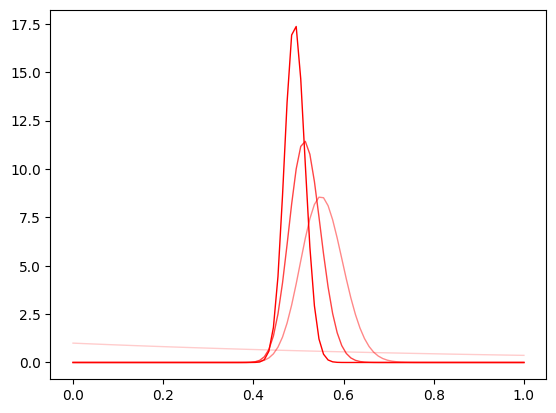

In [1]:
'''
  第7章: Gillespieアルゴリズムとベイズ推定
  - Lotka-Volterra系
  - 図7.7のようなものを描画できる
'''
import numpy as np
import matplotlib.pyplot as plt
import scipy

# パラメータの設定
R = 3
c = [0.5, 0.1, 0.4]
# 状態に依存する関数(propensity function)の設定（学習用データ生成用）
gamma_r = [lambda n: c[0]*n[0],
             lambda n: c[1]*n[0]*n[1],
             lambda n: c[2]*n[1]]
# 各イベントでの状態遷移の設定
v_e = np.array([[+1, 0],
                 [-1,+1],
                 [ 0,-1]])

# ハザード関数の設定（推定用）
hazards = [lambda n: n[0],
          lambda n: n[0]*n[1],
          lambda n: n[1]]

# 乱数の種の設定
rng = np.random.default_rng(641736)

# -------------------------------- 学習データ生成パート
# シミュレーションの設定
sampling_times = [0, 100, 200, 400]
n_ini_low = 3   # 初期化の際の最小個体数
n_ini_high = 10 # 初期化の際の最大個体数

# 定数 gamma0 を計算する関数
def calc_gamma0(n_tilde):
    gamma0 = 0.0
    for gamma in gamma_r:
        gamma0 = gamma0 + gamma(n_tilde)
    return gamma0

# 結果を格納するための変数
chis = np.zeros(R)
integral_gs = np.zeros(R)
result_chis = []
result_integral_gs = []

# サンプリング
t = 0.0
n_tilde = rng.integers(low=n_ini_low,high=n_ini_high,size=2)
sampling_count = 1
pval = np.zeros(R)
gamma0 = calc_gamma0(n_tilde)
result_chis.append(chis.copy())
result_integral_gs.append(integral_gs.copy())
while True:
    tau = rng.exponential(1.0/gamma0)
    # サンプリングの時刻での処理
    if t+tau >= sampling_times[sampling_count]:
        dt = sampling_times[sampling_count]-t
        tmp_integral_gs = integral_gs.copy()
        for r, hazard in enumerate(hazards):
            tmp_integral_gs[r] = integral_gs[r] + hazard(n_tilde)*dt
        # 保存
        result_chis.append(chis.copy())
        result_integral_gs.append(tmp_integral_gs.copy())
        sampling_count = sampling_count + 1
        if sampling_count == (len(sampling_times)):
            break
    t = t + tau
    for r, gamma in enumerate(gamma_r):
        pval[r] = gamma(n_tilde)/gamma0
    e = rng.choice(R, 1, p=pval)[0]
    for r, hazard in enumerate(hazards):
        integral_gs[r] = integral_gs[r] + hazard(n_tilde)*tau
    chis[e] = chis[e]+1
    n_tilde = n_tilde + v_e[e]
    # 絶滅したかどうかの確認: もし絶滅していたら状態を初期化し直す
    if np.all(n_tilde == 0):
        n_tilde = rng.integers(low=n_ini_low,high=n_ini_high,size=2)
    # 種2がなくなると種1が増え続けるだけなので状態を初期化し直す
    if np.all(n_tilde[1] == 0):
        n_tilde = rng.integers(low=n_ini_low,high=n_ini_high,size=2)
    gamma0 = calc_gamma0(n_tilde)
result_chis = np.array(result_chis)
result_integral_gs = np.array(result_integral_gs)

# -------------------------------- 推定パート
alphas = [1.0, 1.0, 1.0]
betas = [1.0, 1.0, 1.0]
result_alphas = []
result_betas = []
for i, chi in enumerate(result_chis):
    tmp = alphas + chi
    result_alphas.append(tmp.copy())
for i, integral_gs in enumerate(result_integral_gs):
    tmp = betas + integral_gs
    result_betas.append(tmp.copy())

# 結果のプロット
x = np.linspace(0.0, 1.0, 100)
plot_r = 0 # (plot_r + 1)番目のイベントの速度定数をプロット
transp = np.linspace(0.2, 1.0, len(sampling_times))
for i, (t, alphas, betas) in enumerate(zip(sampling_times, result_alphas, result_betas)):
    comp = alphas[plot_r]/betas[plot_r]
    print("time: {0}, estimate: {1}".format(t, comp))
    plt.plot(x, scipy.stats.gamma.pdf(x, a=alphas[plot_r], scale=1.0/betas[plot_r]), 'r-',
             lw=1, alpha=transp[i], label='beta pdf')
plt.show()
